Q. diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
- zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']는 0값을 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가

※ 피처 정보  
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압),
'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린),
'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [15]:
file_path='/content/drive/MyDrive/KDT_240424/m5_ML/dataset/diabetes.csv'
diabetes_data=pd.read_csv(file_path)
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [16]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [17]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']는 0값을 평균값으로 대체


In [20]:
# 0값 들어간 케이스 모두 평균값으로 대체
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

def zero_features_apply(diabetes_data, zero_features):
    for feature in zero_features:
        mean_value=diabetes_data[diabetes_data[feature]!=0][feature].mean() # 0인 값 제외하고 각 feature의 평균 값 구하기
        diabetes_data[feature]=diabetes_data[feature].replace(0, mean_value) # 각 feature에 0으로 되어있는 값을 해당 feature의 평균 값으로 대체
    return diabetes_data

diabetes_data=zero_features_apply(diabetes_data, zero_features)

In [21]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성


In [25]:
# train, test 용 데이터 나누기
x=diabetes_data.drop('Outcome', axis=1)
y=diabetes_data['Outcome']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=59)

In [26]:
# 데이터 표준화
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [28]:
# 훈련 및 평가 모델 함수:
def train_and_evaluate(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train) # 모델 훈련 시키기
    y_pred=model.predict(x_test)
    y_proba=model.predict_proba(x_test)[:, 1]

    accuracy=accuracy_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    roc_auc=roc_auc_score(y_test, y_proba)
    confusion=confusion_matrix(y_test, y_pred)
    classification_rep=classification_report(y_test, y_pred)

    print(f"오차 행렬: \n{confusion}")
    print(f"정확도: {accuracy: .4f}")
    print(f"정밀도: {precision: .4f}")
    print(f"재현율: {recall: .4f}")
    print(f"f1 스코어: {f1: .4f}")
    print(f"ROC AUC: {roc_auc: .4f}")
    print(f'Classification Report: {classification_rep}')

In [41]:
# 훈련 및 평가 모델:
# 여러 모델 훈련 및 평가
models={
    'Logistic Regression': LogisticRegression(solver='lbfgs', random_state=59),
    'Random Forest': RandomForestClassifier(random_state=59),
    'Deceision Tree': DecisionTreeClassifier(random_state=59),
    'SVM_linear': SVC(kernel='linear', probability=True, C=1.0, random_state=59),
    'SVM_poly': SVC(kernel='poly', probability=True, C=1.0, random_state=59),
    'SVM_rbf': SVC(kernel='rbf', probability=True, C=1.0, random_state=59),
    'GBM': GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=59),
    'XGB': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'LGBM': LGBMClassifier(n_estimators=100, learning_rate=0.05, verbose=-1),
    'GNB': GaussianNB()
}

# 각 모델별 함수 실행
for model_name, model in models.items():
    print(f'[{model_name}]')
    train_and_evaluate(model, x_train, x_test, y_train, y_test)

[Logistic Regression]
오차 행렬: 
[[88 12]
 [26 28]]
정확도:  0.7532
정밀도:  0.7000
재현율:  0.5185
f1 스코어:  0.5957
ROC AUC:  0.8037
Classification Report:               precision    recall  f1-score   support

           0       0.77      0.88      0.82       100
           1       0.70      0.52      0.60        54

    accuracy                           0.75       154
   macro avg       0.74      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154

[Random Forest]
오차 행렬: 
[[83 17]
 [25 29]]
정확도:  0.7273
정밀도:  0.6304
재현율:  0.5370
f1 스코어:  0.5800
ROC AUC:  0.8102
Classification Report:               precision    recall  f1-score   support

           0       0.77      0.83      0.80       100
           1       0.63      0.54      0.58        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154

[Deceision Tree]
오차 행렬: 
[[77 23]
 [25 29]]
정확도:  0.6883
정밀도:  0

In [ ]:
# 시도한 10가지 중:
# LGBM, XGB (0.759) > GBM, LogisticRegression (0.753) 이 가장 정확도가 높음
# LGBM이 XGB 보다 재현율이 미세하게 높음.

# [LGBM]
# 오차 행렬:
# [[83 17]
#  [20 34]]
# 정확도:  0.7597
# 정밀도:  0.6667
# 재현율:  0.6296
# f1 스코어:  0.6476
# ROC AUC:  0.8306
# Classification Report:               precision    recall  f1-score   support

#            0       0.81      0.83      0.82       100
#            1       0.67      0.63      0.65        54

#     accuracy                           0.76       154
#    macro avg       0.74      0.73      0.73       154
# weighted avg       0.76      0.76      0.76       154

정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화


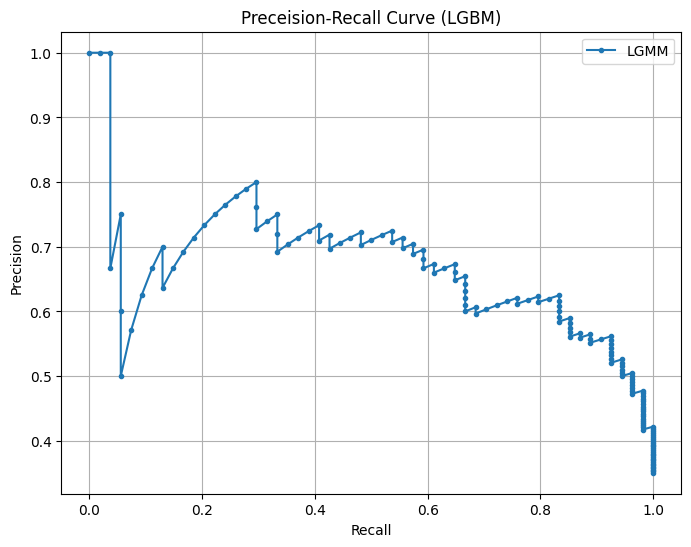

In [44]:
# [LGBM] 모델로 진행
# GPT의 제안:
model=LGBMClassifier(n_estimators=100, learning_rate=0.05, verbose=-1) # 위 함수에서 돌린 것 중 최적 그대로 따와서
model.fit(x_train, y_train) # 모델 훈련 시키기
y_pred=model.predict(x_test)
y_proba=model.predict_proba(x_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='LGMM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Preceision-Recall Curve (LGBM)')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# 수업 내용 활용 (1/2):
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import Binarizer

pred_proba=model.predict_proba(x_test)

# 임곗값을 0.5로 설정.
custom_threshold=0.5

# 양성 확률 추출 후 2차원 배열로 변환
pred_proba_1=pred_proba[:, 1].reshape(-1,1)
# pred_proba_1=pred_proba[:,1]
print('양성확률: \n', pred_proba_1[0:5])
print()
binarizer=Binarizer(threshold=custom_threshold)
custom_predict=binarizer.fit_transform(pred_proba_1)
custom_predict[0:5]

def get_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    f1=f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, f1 score: {3:.4f}'.format(accuracy, precision, recall, f1))

get_clf_eval(y_test, custom_predict)

양성확률: 
 [[0.16148471]
 [0.02534451]
 [0.08188299]
 [0.77990292]
 [0.5129262 ]]

오차 행렬
[[83 17]
 [20 34]]
정확도: 0.7597, 정밀도: 0.6667, 재현율: 0.6296, f1 score: 0.6476


[0.0029034892693371515, 0.0037102600741302375, 0.003961951710538498, 0.00436267898926442, 0.004620067935396499, 0.006532037097865472, 0.008630295859686544, 0.008828231895330798, 0.010709442274576118, 0.011613067852558872, 0.012773527020838915, 0.013047871878785233, 0.013084288017459542, 0.013451285803441258, 0.014606127989788479, 0.014698958049922184, 0.01497107218239611, 0.016128204292882236, 0.01776465215489256, 0.018292283403461243, 0.01838201704903744, 0.018661904161115607, 0.023403497732825598, 0.023650071876187784, 0.0238327040106997, 0.024178333440661667, 0.024587830649625417, 0.025344512730136153, 0.025396772562261645, 0.026378832533668493, 0.02659567884999086, 0.027751579859768543, 0.03082004240055823, 0.03110007768488108, 0.03117935973640658, 0.032167103867962, 0.03447101134904879, 0.035727073383662815, 0.03656171842732761, 0.036713551466360475, 0.03767217775021109, 0.03997296997958775, 0.040044332394880706, 0.04104602936147033, 0.04220523300807105, 0.04349616979586006, 0.045

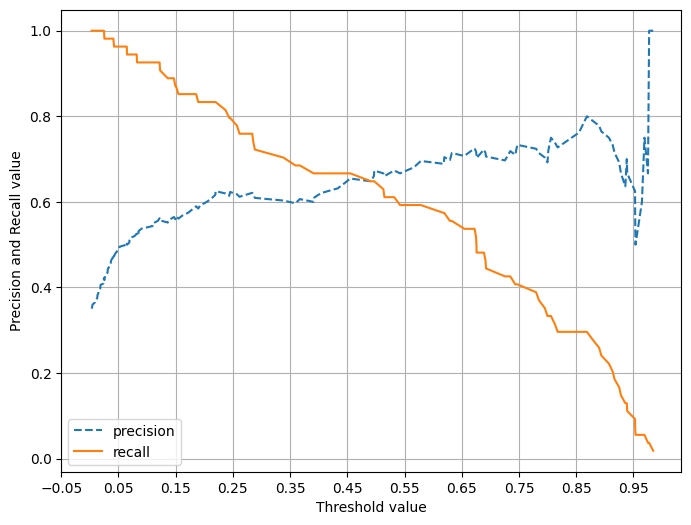

In [47]:
# 수업 내용 활용 (2/2):

thresholds=[0.4, 0.45, 0.50, 0.55, 0.60, 0.65]
pred_proba_c1=pred_proba[:,1].reshape(-1,1) # 양성 클래스 선택하여 1차원 배열로 결과 반환 & 2차원 배열 (열 벡터)로 변환


def precision_recall_curve_plot(y_test, pred_proba_c1): # 실제 라벨 (y_test)와 예측 확률 (pred_proba_c1) 사용하여 precision-recall 곡선 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    print(list(thresholds))
    print(thresholds.shape)
    threshold_boundary=thresholds.shape[0] # thresholds 배열의 길이를 계산하여 threshold_boundary 변수에 저장
                                           # 이 값을 사용하여 precision과 recall 곡선을 그릴 때 인덱스 범위를 조정
                                           # ==> 곡선을 그릴 대 precision과 recall 값의 개수를 맞추기 위해 사용
    print(threshold_boundary)

    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions[0: threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, model.predict_proba(x_test)[:, 1])

전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출


산출된 임계값을 적용한 평가

## 강사님 풀이

In [ ]:
file_path='/content/drive/MyDrive/KDT_240424/m5_ML/dataset/diabetes.csv'
diabetes_data=pd.read_csv(file_path)
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)